# Steering Fraction Evaluation — Line Plot

This notebook plots evaluation loss vs. fraction of features used during the steering-fraction sweep experiment.

Style and structure are adapted from the existing `wandb_results_plotting.ipynb`.

In [11]:
import os
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Plotting style (inspired by existing notebook)
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'font.family': 'sans-serif',
    'text.usetex': False,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linewidth': 1.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'legend.frameon': False,
    'legend.fontsize': 11,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Color palette
colors = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#C73E1D',
    'neutral': '#6C757D',
    'light': '#E9ECEF'
}

print('Plotting environment initialized.')

Plotting environment initialized.


## Configure W&B Source

In [12]:
# Configure your W&B entity/project and (optionally) a specific run to plot
entity = 'feature-steering-rl'   # adjusted to match existing notebook casing
project = 'fsrl-steering-fraction-eval'
run_name = "effortless-cherry-6"  # e.g., 'mild-glade-10' to force a specific run; None -> latest finished

api = wandb.Api()
print(f'Using W&B: {entity}/{project}')

Using W&B: feature-steering-rl/fsrl-steering-fraction-eval


## Fetch Run and Build Data

In [13]:
# Find the run: by display name if provided, otherwise latest finished
runs = api.runs(f'{entity}/{project}')
finished = [r for r in runs if r.state == 'finished']
if not finished:
    raise RuntimeError('No finished runs found in the project.')

if run_name is not None:
    picked = [r for r in finished if r.name == run_name]
    if not picked:
        raise RuntimeError(f'Run named {run_name!r} not found among finished runs.')
    run = picked[0]
else:
    # pick latest by updated time
    run = sorted(finished, key=lambda r: r.updated_at, reverse=True)[0]

print('Selected run:', run.name, run.id)

# Pull history for the logged metrics from the sweep script
hist = run.history(keys=['steering_fraction', 'eval/loss'], pandas=True)
raw = hist[['steering_fraction', 'eval/loss']].dropna()
# Average across duplicate fractions if logged multiple times
agg = raw.groupby('steering_fraction', as_index=False)['eval/loss'].mean()
df = agg.sort_values('steering_fraction').reset_index(drop=True)
print('Data points (unique fractions):', len(df))
df.head()

Selected run: effortless-cherry-6 y9gaqdec
Data points (unique fractions): 11


,steering_fraction,eval/loss
0,0.0001,6.976641
1,0.0002,6.966243
2,0.0004,6.939398
3,0.0008,6.893339
4,0.0016,6.773200


## Line Plot: Evaluation Loss vs Steering Fraction

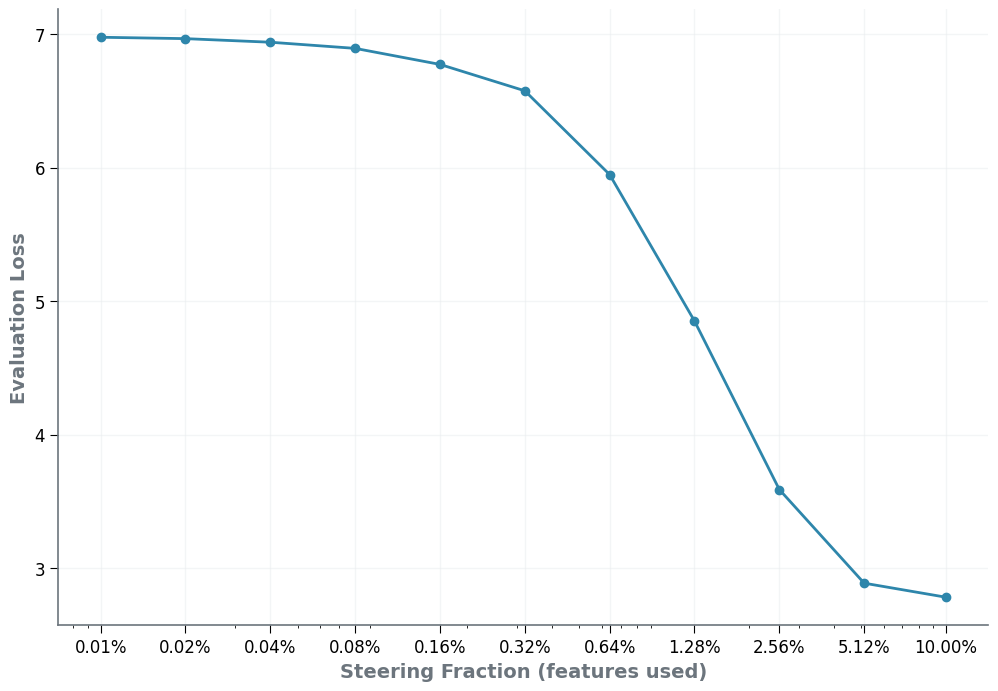

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('#FFFFFF')

# Ensure strictly positive fractions for log-scale
plot_df = df[df['steering_fraction'] > 0].copy()

# Line plot with markers
ax.plot(
    plot_df['steering_fraction'],
    plot_df['eval/loss'],
    color=colors['primary'],
    marker='o',
    linewidth=2,
    markersize=6,
    label=run.name
)

# Use logarithmic x-scale based on data distribution
ax.set_xscale('log')
# Place ticks at the actual data fractions
xticks = sorted(plot_df['steering_fraction'].unique().tolist())
ax.set_xticks(xticks)

# Enhance styling to match existing style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(1.2)
    ax.spines[spine].set_color(colors['neutral'])

ax.grid(True, alpha=0.5, linestyle='-', linewidth=1.0, color=colors['light'])
ax.set_axisbelow(True)

# Axis labels and title
ax.set_xlabel('Steering Fraction (features used)', fontsize=14, fontweight='bold', color=colors['neutral'])
ax.set_ylabel('Evaluation Loss', fontsize=14, fontweight='bold', color=colors['neutral'])
# ax.set_title('Evaluation Loss vs Steering Fraction', fontsize=16, fontweight='bold', color=colors['neutral'], pad=20)

# Format x-axis as percentages for readability
from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))

# ax.legend(loc='best')
plt.show()

## Save Data and Figure

In [17]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

csv_path = os.path.join(output_dir, f'{run.name}_steering_fraction_eval.csv')
png_path = os.path.join(output_dir, f'{run.name}_eval_loss_vs_fraction.png')
pdf_path = os.path.join(output_dir, f'{run.name}_eval_loss_vs_fraction.pdf')

# Save data and figure
df.to_csv(csv_path, index=False)

# Ensure the plotted figure exists in scope
try:
    fig
except NameError:
    raise RuntimeError('Plot figure not found. Please run the plotting cell first.')

# Ensure the canvas is drawn before saving (avoids blank images on some backends)
fig.canvas.draw()

# Save as PNG
fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='#FAFAFA', edgecolor='none')

# Save as PDF (high quality vector format)
fig.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='#FAFAFA', edgecolor='none')

print('Saved:')
print(' -', csv_path)
print(' -', png_path)
print(' -', pdf_path)

Saved:
 - outputs/effortless-cherry-6_steering_fraction_eval.csv
 - outputs/effortless-cherry-6_eval_loss_vs_fraction.png
 - outputs/effortless-cherry-6_eval_loss_vs_fraction.pdf
